In [3]:
# import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
from scipy import stats
from datetime import datetime
from sklearn.cluster import KMeans
#from wordcloud import WordCloud, STOPWORDS
from nltk import *
# Only need if package not found
#nltk.download('punkt')
#nltk.download("averaged_perceptron_tagger")
#nltk.download('stopwords')
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib as mpl
import matplotlib.cm as cm
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from mpl_toolkits.mplot3d import Axes3D
pd.set_option('display.max_columns', 30)

In [4]:
# Load data and Save as dataframe format
df = pd.read_excel('Online Retail.xlsx')

In [5]:
# Remove the duplicates
df = df.drop_duplicates()
print ("Dateframe Dimension after drop duplicates:", df.shape)

Dateframe Dimension after drop duplicates: (536641, 8)


In [6]:
# Remove outlier in the data (abnormal Q'ty and unitprice)
df = df[ (np.abs(stats.zscore(df.Quantity)) <= 3) & (np.abs(stats.zscore(df.Quantity)) <= 3)]
print ("Dateframe Dimension after drop outliers:", df.shape)

Dateframe Dimension after drop outliers: (536298, 8)


In [7]:
# Remove the Quantity < 0 and Uniprice = 0
df = df[ (df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print ("Dateframe Dimension after drop meaningless order:", df.shape)

Dateframe Dimension after drop meaningless order: (524643, 8)


In [8]:
# Drop NaN value
df = df.dropna()
df['CustomerID']= df['CustomerID'].astype(str)
print ("Dateframe Dimension after drop NaN:", df.shape)

Dateframe Dimension after drop NaN: (392460, 8)


In [9]:
# Separate InvoiceDate into Date and Time
df['Date'] = [d.date() for d in df['InvoiceDate']]
df['Time'] = [d.time() for d in df['InvoiceDate']]
# drop InvoiceDate Column
df = df.drop(columns=['InvoiceDate'])
display(df.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice',
       'CustomerID', 'Country', 'Date', 'Time'],
      dtype='object')

In [10]:
#Create "Amount" attrivutes, which is Q'ty * Unit price
df['Amount'] = df['Quantity'] * df['UnitPrice']
print ("Dateframe Dimension after adding 'Amount':", df.shape)

Dateframe Dimension after adding 'Amount': (392460, 10)


In [11]:
# Create Holiday Label based on date
# Load uk holidays.csv as dataframe
uk_holiday_df = pd.read_csv('UK Bank Holidays.csv')
uk_holiday_df['Date'] = pd.to_datetime(uk_holiday_df['Date'])
# Refine df for only Name and Date
uk_holiday_df = uk_holiday_df[['Date','Name']]
mask = (uk_holiday_df['Date'] > '2010-12-01') & (uk_holiday_df['Date'] <= '2011-12-09')
uk_holiday_df = uk_holiday_df.loc[mask]
uk_holiday_df['Date'] = [d.date() for d in uk_holiday_df['Date']]
# Create Column 'Holiday'
holiday_date = uk_holiday_df['Date'].tolist()
holiday_name = uk_holiday_df['Name'].tolist()
i = 0
days = 7 # the days count for holiday sales
for d in uk_holiday_df['Date']:
    cutoff_date = d - pd.Timedelta(days = days)
    period = (df['Date'] > cutoff_date) & (df['Date'] <= d)
    df.loc[ period ,'Holiday'] = holiday_name[i]
    i+=1
df['Holiday'].fillna(value='Non-Holiday', inplace=True)
print ("Dateframe Dimension after adding 'Holiday':", df.shape)

Dateframe Dimension after adding 'Holiday': (392460, 11)


In [12]:
# Create Tf-idf Matrix
corpus = df['Description'].unique()
v = TfidfVectorizer(stop_words='english')
matrix = v.fit_transform(corpus)
tfidf_df = pd.DataFrame(matrix.toarray(), columns=v.get_feature_names())

In [13]:
# Test the best number of cluster by silhouette score
test_range = range(2,15)
sse=[]
for n_clusters in test_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=11)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sse.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("Clusters = {}".format(n_clusters),"the silhouette score = {}".format(round(silhouette_avg,8)))

Clusters = 2 the silhouette score = 0.0054291
Clusters = 3 the silhouette score = 0.0076032
Clusters = 4 the silhouette score = 0.01018537
Clusters = 5 the silhouette score = 0.01464577
Clusters = 6 the silhouette score = 0.01144713
Clusters = 7 the silhouette score = 0.01672463
Clusters = 8 the silhouette score = 0.01752241
Clusters = 9 the silhouette score = 0.01824695
Clusters = 10 the silhouette score = 0.02094104
Clusters = 11 the silhouette score = 0.02487662
Clusters = 12 the silhouette score = 0.02339508
Clusters = 13 the silhouette score = 0.02510542
Clusters = 14 the silhouette score = 0.02892038


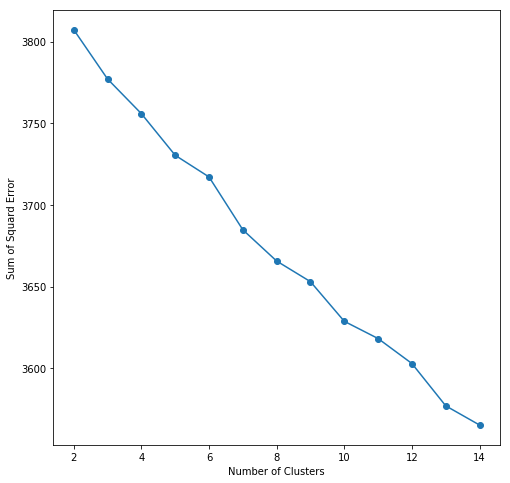

In [14]:
# Plot sse against n_clusters in elbow method
plt.figure(figsize=(8, 8))
plt.plot(list(test_range), sse, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squard Error');

In [15]:
# Normalization for tdidf values. If we don't handle this, the unitprice attributes will dominant the similiarity
tfidf_norm = (tfidf_df-tfidf_df.min())/(tfidf_df.max()-tfidf_df.min())

In [16]:
# Create UnitPrice dummy attributes
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    tfidf_norm.loc[:, col] = 0

for i, prod in enumerate(corpus):
    prix = df[ df['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    tfidf_norm.loc[i, label_col[j-1]] = 1

In [17]:
# Check the UnitPrice dummy if correct
display(tfidf_norm.head(10))

,10,11,12,120cm,125g,15,15c,15cm,16,16x16cm,17080,18pc,20,200,20light,...,wrap,wrapping,wreath,wrecking,writing,xmas,yellow,yuletide,zinc,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0


Clusters = 2 the silhouette score = 0.06538186
Clusters = 3 the silhouette score = 0.09724077
Clusters = 4 the silhouette score = 0.12016327
Clusters = 5 the silhouette score = 0.13877118
Clusters = 6 the silhouette score = 0.14685255
Clusters = 7 the silhouette score = 0.12334044
Clusters = 8 the silhouette score = 0.12786251
Clusters = 9 the silhouette score = 0.09791019
Clusters = 10 the silhouette score = 0.08393052
Clusters = 11 the silhouette score = 0.06250468
Clusters = 12 the silhouette score = 0.08027535
Clusters = 13 the silhouette score = 0.04611965
Clusters = 14 the silhouette score = 0.02450123


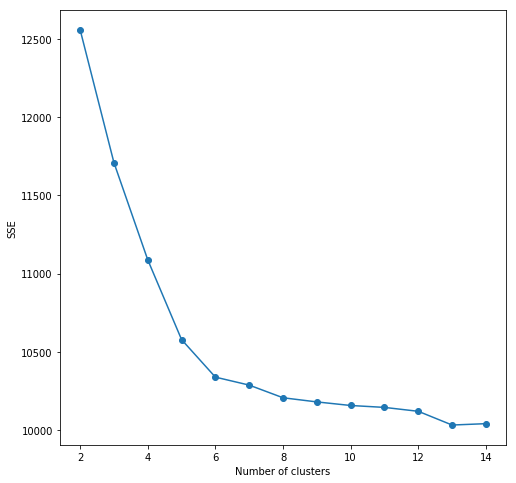

In [18]:
matrix = tfidf_norm.values
sse=[]
for n_clusters in test_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    sse.append(kmeans.inertia_)
    print("Clusters = {}".format(n_clusters),"the silhouette score = {}".format(round(silhouette_avg,8)))
    

# Plot sse against n_clusters
plt.figure(figsize=(8, 8))
plt.plot(list(test_range), sse, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE');

In [19]:
# I think this orginal purpose for part is just make sue 
# the model for word cloud can be close to or better the model we did above.
# By controling the silhouette_score can make sure the result as we expect.
n_clusters = 6
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("Clusters = {}".format(n_clusters),"the silhouette score = {}".format(round(silhouette_avg,8)))

Clusters = 6 the silhouette score = 0.14685255


In [20]:
# Check clusters distribution 
pd.Series(clusters).value_counts()

0    1008
2     964
1     672
5     606
4     470
3     155
dtype: int64

In [21]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

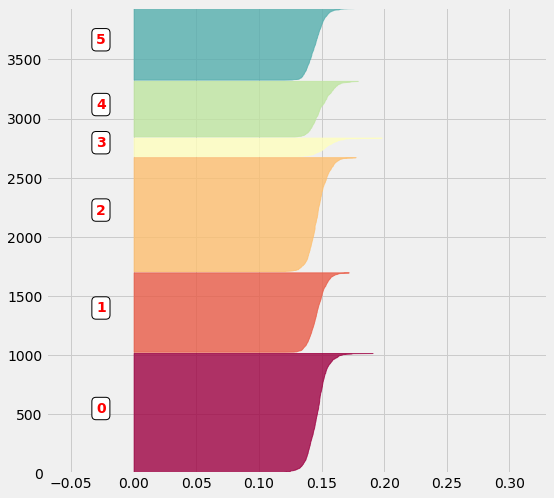

In [22]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(tfidf_df), sample_silhouette_values, clusters)

In [24]:
# Plot word cloud
d_list = df['Description'].unique().tolist()
prod_cluster = defaultdict(list)
for i in range(len(clusters)):
    cluster_num = clusters[i]
    prod_cluster[cluster_num].append(d_list[i])
for i in range(len(prod_cluster)):
    s = " "
    words = s.join(prod_cluster[i])
    wordcloud = WordCloud().generate(text = words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('cluster {}'.format(i))
    plt.show()


'\nd_list = df[\'Description\'].unique().tolist()\nprod_cluster = defaultdict(list)\nfor i in range(len(clusters)):\n    cluster_num = clusters[i]\n    prod_cluster[cluster_num].append(d_list[i])\nfor i in range(len(prod_cluster)):\n    s = " "\n    words = s.join(prod_cluster[i])\n    wordcloud = WordCloud().generate(text = words)\n    plt.imshow(wordcloud, interpolation=\'bilinear\')\n    plt.axis("off")\n    plt.title(\'cluster {}\'.format(i))\n    plt.show()\n'

In [25]:
#RFM-Recency: how long since the last purchase of a customer in days
df["lenOfPurchase"] = df["Date"].max()-df["Date"]
df["lenOfPurchase"] = df["lenOfPurchase"].map(lambda x: x.days)
df["Recency"] = df["CustomerID"].map(df.groupby("CustomerID")["lenOfPurchase"].min().to_dict().get)

#RFM-Monetary: the total amount that one customer spent on all purchases
df["Monetary"] = df["CustomerID"].map(df.groupby("CustomerID")["Amount"].sum().to_dict().get)

#RFM-Frequency: how many orders one customer placed in terms of unique invoice#
df["Frequency"] = df["CustomerID"].map(df.groupby("CustomerID")["InvoiceNo"].nunique().to_dict().get)

df.head(3)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Amount,Holiday,lenOfPurchase,Recency,Monetary,Frequency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30,Non-Holiday,373,372,5391.21,34
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,Non-Holiday,373,372,5391.21,34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00,Non-Holiday,373,372,5391.21,34


In [26]:
# Add product category entry in major df
prod_cluster_inv = {}
for k,v in prod_cluster.items():
    for i in v:
        prod_cluster_inv[i] = k

df["ProdCate"] = df["Description"].map(prod_cluster_inv.get)

df.head(3)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Amount,Holiday,lenOfPurchase,Recency,Monetary,Frequency,ProdCate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30,Non-Holiday,373,372,5391.21,34,1
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,Non-Holiday,373,372,5391.21,34,5
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00,Non-Holiday,373,372,5391.21,34,5


In [27]:
# Add spending for each product category
for i in range(6):
    cate = "cate_" + str(i)
    current_cate_amount = df[df["ProdCate"]==i]["Amount"]
    current_cate_amount = current_cate_amount
    df.loc[:, cate] = current_cate_amount

df = df.fillna(0)

df.head(3)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Amount,Holiday,lenOfPurchase,Recency,Monetary,Frequency,ProdCate,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30,Non-Holiday,373,372,5391.21,34,1,0.0,15.3,0.0,0.0,0.0,0.00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,Non-Holiday,373,372,5391.21,34,5,0.0,0.0,0.0,0.0,0.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00,Non-Holiday,373,372,5391.21,34,5,0.0,0.0,0.0,0.0,0.0,22.00


In [28]:
# type transformation
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['CustomerID'] = df['CustomerID'].astype('float').astype('int').astype('str')

In [29]:
#customer cluster
customer_spent = df.groupby(["CustomerID", "InvoiceNo"], as_index=False)["Amount"].sum()

for i in range(6):
    cate = "cate_"+str(i)
    customer_invoice_spending = df.groupby(["CustomerID", "InvoiceNo"], as_index=False)[cate].sum()
    customer_spent.loc[:, cate] = customer_invoice_spending
customer_spent = customer_spent.groupby('CustomerID',as_index=False).sum()    
customer_spent.head(3)

,CustomerID,Amount,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5
0,12347,4310.00,1136.80,896.70,484.32,191.25,327.74,1273.19
1,12348,1797.24,754.00,0.00,683.24,360.00,0.00,0.00
2,12349,1757.55,465.86,215.22,79.32,450.50,358.35,188.30


In [30]:
# Customer Segementation on RFM model
customers_rfm = pd.DataFrame()
customers_rfm['CustomerID'] = df['CustomerID'].unique()
customers_rfm["Frequency"] = customers_rfm["CustomerID"].map(df.groupby("CustomerID")["InvoiceNo"].nunique().to_dict().get)
customers_rfm['Recency'] = customers_rfm['CustomerID'].map((df['Date'].max()-df.groupby('CustomerID')['Date'].max()).to_dict().get)
customers_rfm = pd.merge(customers_rfm,customer_spent,on='CustomerID')
customers_rfm['Recency'] = customers_rfm['Recency'].dt.days
customers_rfm.head(10)

,CustomerID,Frequency,Recency,Amount,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5
0,17850,34,372,5391.21,594.12,1048.50,0.00,607.75,1262.80,1878.04
1,13047,10,31,3237.54,494.78,536.48,277.18,145.75,826.45,956.90
2,12583,15,2,7281.38,1532.50,1166.40,1448.88,806.25,245.25,2082.10
3,13748,5,95,948.25,147.00,577.32,52.68,93.65,29.40,48.20
4,15100,3,333,876.00,0.00,0.00,0.00,876.00,0.00,0.00
5,15291,15,25,4668.30,978.46,500.76,207.48,224.05,1972.95,784.60
6,14688,21,7,5579.10,1140.47,2120.08,900.10,25.00,428.85,964.60
7,17809,12,16,5411.91,1232.89,783.00,127.38,0.00,1843.15,1425.49
8,15311,91,0,60632.75,18800.67,22712.55,4780.97,755.00,7703.65,5879.91
9,16098,7,87,2005.63,93.30,551.96,45.67,528.20,382.50,404.00


In [31]:
# Normalization RFM dataframe
col = ['Frequency','Recency','cate_0','cate_1','cate_2','cate_3','cate_4','cate_5']
norm = (customers_rfm[col]-customers_rfm[col].min())/(customers_rfm[col].max()-customers_rfm[col].min())
customers_rfm[col] = norm[col]
customers_rfm.head(10)

,CustomerID,Frequency,Recency,Amount,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5
0,17850,0.158654,0.997319,5391.21,0.005971,0.015152,0.000000,0.015340,0.007820,0.044882
1,13047,0.043269,0.083110,3237.54,0.004972,0.007753,0.007918,0.003679,0.005118,0.022868
2,12583,0.067308,0.005362,7281.38,0.015401,0.016855,0.041387,0.020350,0.001519,0.049759
3,13748,0.019231,0.254692,948.25,0.001477,0.008343,0.001505,0.002364,0.000182,0.001152
4,15100,0.009615,0.892761,876.00,0.000000,0.000000,0.000000,0.022110,0.000000,0.000000
5,15291,0.067308,0.067024,4668.30,0.009833,0.007236,0.005927,0.005655,0.012218,0.018751
6,14688,0.096154,0.018767,5579.10,0.011461,0.030637,0.025711,0.000631,0.002656,0.023052
7,17809,0.052885,0.042895,5411.91,0.012390,0.011315,0.003639,0.000000,0.011414,0.034067
8,15311,0.432692,0.000000,60632.75,0.188937,0.328213,0.136567,0.019056,0.047705,0.140521
9,16098,0.028846,0.233244,2005.63,0.000938,0.007976,0.001305,0.013332,0.002369,0.009655


In [32]:
train = customers_rfm.drop(['CustomerID','Amount'],axis=1) 
train.head(10)

,Frequency,Recency,cate_0,cate_1,cate_2,cate_3,cate_4,cate_5
0,0.158654,0.997319,0.005971,0.015152,0.000000,0.015340,0.007820,0.044882
1,0.043269,0.083110,0.004972,0.007753,0.007918,0.003679,0.005118,0.022868
2,0.067308,0.005362,0.015401,0.016855,0.041387,0.020350,0.001519,0.049759
3,0.019231,0.254692,0.001477,0.008343,0.001505,0.002364,0.000182,0.001152
4,0.009615,0.892761,0.000000,0.000000,0.000000,0.022110,0.000000,0.000000
5,0.067308,0.067024,0.009833,0.007236,0.005927,0.005655,0.012218,0.018751
6,0.096154,0.018767,0.011461,0.030637,0.025711,0.000631,0.002656,0.023052
7,0.052885,0.042895,0.012390,0.011315,0.003639,0.000000,0.011414,0.034067
8,0.432692,0.000000,0.188937,0.328213,0.136567,0.019056,0.047705,0.140521
9,0.028846,0.233244,0.000938,0.007976,0.001305,0.013332,0.002369,0.009655


Clusters = 2 the silhouette score = 0.71337441
Clusters = 3 the silhouette score = 0.63091337
Clusters = 4 the silhouette score = 0.53464871
Clusters = 5 the silhouette score = 0.54996841
Clusters = 6 the silhouette score = 0.5391224
Clusters = 7 the silhouette score = 0.5129416
Clusters = 8 the silhouette score = 0.52224239
Clusters = 9 the silhouette score = 0.44207855
Clusters = 10 the silhouette score = 0.44228434
Clusters = 11 the silhouette score = 0.44257304
Clusters = 12 the silhouette score = 0.45098616
Clusters = 13 the silhouette score = 0.45344333
Clusters = 14 the silhouette score = 0.45518151
Clusters = 15 the silhouette score = 0.44551379
Clusters = 16 the silhouette score = 0.43894368
Clusters = 17 the silhouette score = 0.44608932
Clusters = 18 the silhouette score = 0.43802815
Clusters = 19 the silhouette score = 0.42414507
Clusters = 20 the silhouette score = 0.42475658
Clusters = 21 the silhouette score = 0.43267008
Clusters = 22 the silhouette score = 0.41805918
Cl

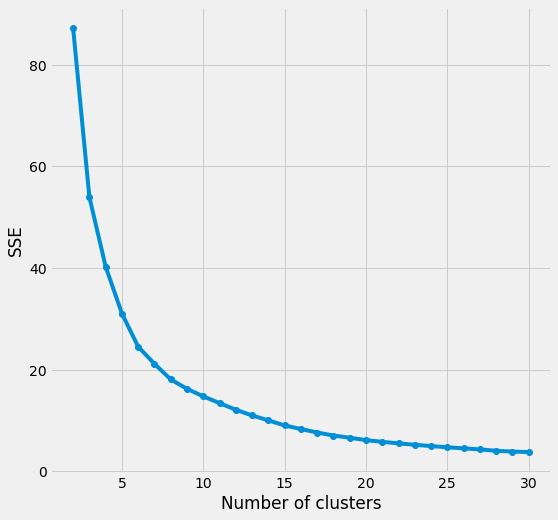

In [33]:
matrix = train.values
sse=[]
for n_clusters in range(2,31):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    sse.append(kmeans.inertia_)
    print("Clusters = {}".format(n_clusters),"the silhouette score = {}".format(round(silhouette_avg,8)))
    
# Plot sse against n_clusters
plt.figure(figsize=(8, 8))
plt.plot(list(range(2,31)), sse, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE');